# Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Arrow
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid.inset_locator import inset_axes
%matplotlib notebook

import re
from scipy.integrate import odeint, solve_ivp

# Decalaring Paths

In [3]:
results_path = '../Notebook Results/Chapter 1/'

# Initializations

In [4]:
%%html
<style>
.output_wrapper button.btn.btn-default,
.output_wrapper .ui-dialog-titlebar {
  display: none;
}
</style>

In [5]:
plt.rcParams['figure.dpi'] = 80
plt.rcParams['figure.figsize'] = (12.5,6)

# Body Mass Simulation

**Plane Surface Without Air Drag**

\begin{equation}
\begin{aligned}
F &= ma \\
-\mu mg &\Leftrightarrow ma \\
ma &= -\mu mg \\
\frac{dv}{dt} &= -\mu g \\
\int_{\mathrm{t}=0}^{\mathrm{t}=t} dv &= \int_{\mathrm{t}=0}^{\mathrm{t}=t}-\mu g dt \\
v - v_{0}&= - \mu gt\\
v &= v_{0} - \mu gt\\
\end{aligned}
\end{equation}


**Plane Surface With Air Drag**

\begin{equation}
\begin{aligned}
F &= ma \\
-\mu mg &\Leftrightarrow ma \\
ma &= -\mu mg \\ \\ \\
Adding\ the\ Air\ Drag\ Factor\ -\delta \\
\frac{dv}{dt} &= -\mu g - \delta v\\
\int_{\mathrm{v}=v_{0}}^{\mathrm{v}=v} \frac{dv}{-\mu g - \delta v} &= \int_{\mathrm{t}=0}^{\mathrm{t}=t}dt \\
-\frac{1}{\delta} ln \left(\frac{-\mu g - \delta v}{-\mu g - \delta v_{0}}\right) &= t - 0 \\
\frac{-\mu g - \delta v(t)}{-\mu g - \delta v_{0}} &= e^{-\delta t} \\
v(t) &= (\frac{\delta}{\mu} g + v_{0})e^{-\delta t} - \frac{\delta}{\mu} g\\
\end{aligned}
\end{equation}

In [6]:
class PlaneSimulator:
    
    def __init__(self, mass_pos_0 = (0,0), vel_0 = 20, mu_s = 0.01, 
                 g_force = 9.8, air_drag = 0.01, body_mass = 2, 
                 timesteps = 30, vector_skips=5, interval=5):
        
        self.plane = 0.2
        
        self.mass_pos_x_0 = mass_pos_0[0]
        self.mass_pos_y_0 = mass_pos_0[1] + self.plane
        self.vel_0        = vel_0
        
        self.mass_height  = 0.03
        self.mass_width   = 2.0
        self.mass_pos_x_0 = self.mass_pos_x_0 + self.mass_width/2
        self.mass_pos_y_0 = self.mass_pos_y_0
        
        self.mu_s = mu_s
        self.g_force = g_force
        self.air_drag = air_drag
        self.body_mass = body_mass
        
        self.timesteps = timesteps
        self.sim_time = np.linspace(0, self.timesteps, 20*(self.timesteps)+1)
        self.interval = interval
        
    @staticmethod
    def get_deriv(t, state, g, mu, ad):
        
        _pos_x = state[0]
        _pos_y = state[1]
        _vel = state[2]
        
        d_pos_x = _vel
        d_pos_y = 0
        d_vel = - mu*g*t - ad*_vel if _vel > 0 else 0.0# Infinitesmly Small Acceleration
        
        next_sate = [d_pos_x, d_pos_y, d_vel]

        return next_sate

    def calculate_deriv(self):
        
        state_0 = [self.mass_pos_x_0, self.mass_pos_y_0, self.vel_0]
        oderes = odeint(self.get_deriv, state_0 , self.sim_time,
                        args=(self.g_force, self.mu_s, self.air_drag), 
                        tfirst=True)
        
        self._pos_x, self._pos_y, self._vel = oderes.T
        self._accel = -np.array([self.g_force*self.mu_s]*self._vel.shape[0]) - self.air_drag*self._vel
        self.oderes = np.c_[self._pos_x, self._pos_y, self._vel, self._accel]
        self.velocity_vector = self.oderes[:,2]/max(self.oderes[:,2])
        
    def init_plot(self):
        
        # Basic Axes setup
        if self.air_drag == 0.0:
            self.axes.set_title(r'$Dynamics\ Of\ Motion\ in\ Plane$')
        else:
            self.axes.set_title(r'$Dynamics\ Of\ Motion\ in\ Plane\ With\ Air\ Drag$')
        self.axes.set_facecolor('k')
        self.axes.get_yaxis().set_ticks([])
        self.axes.set_xlim(0, np.max(self.oderes[:,0])*1.2)
        self.axes.set_ylim(0, self.plane*1.5)

        # Create plane
        self.axes.fill_between(np.linspace(0, np.max(self.oderes[:,0])*1.2, 10000),
                               self.plane, 0,
                               color='#e8a864')

        # Set up the mass
        pos_x, pos_y = self.oderes[:,0][0]+self.mass_width/4, self.oderes[:,1][0]+self.mass_height/4
        vel_0 = self.oderes[:,2][0]
        bboxprop = dict(facecolor='wheat',boxstyle='round', color='w', lw=2)
        self.masstext = self.axes.text(pos_x, pos_y, r'$m$', color='#63492a', fontsize = 20, bbox = bboxprop)
        self.velocity_vector = self.axes.annotate('$Velocity$ = '+str(vel_0) + '$ms^{-1}$', xy=(pos_x+15,pos_y), xytext=(50,pos_y-.003), color='w',
                                                   arrowprops = {'arrowstyle': "<|-", 'color':'w'})
        
        # Set up the Time Patch
        bbox_prop = dict(facecolor='wheat',boxstyle='round', edgecolor='w', lw=3)
        self.time_text = r'$Time : {0}$'.format(self.sim_time[0])
        self.timetext = self.fig.text(0.8, 0.85, self.time_text,
                                       color='#63492a', fontsize = 20,
                                       bbox = bbox_prop)

        # Setup the Velocity and Acceleration axes
        self.va_axes = inset_axes(self.axes, width="40%", height="30%", loc=4,
                                  bbox_to_anchor=(-0.12,0.1,1,1), bbox_transform=self.axes.transAxes)
        self.va_axes.patch.set_alpha(0.5)
        self.va_axes.set_facecolor('#ffefd6')
        for spine in self.va_axes.spines.values(): spine.set_edgecolor('white')
        self.va_axes.grid(color='w', linestyle='-.', linewidth=0.3)
        self.va_axes.tick_params(axis='both', colors='w')
        self.va_axes.set_xlabel(r'$Time \longrightarrow$', color='w')
        self.va_axes.set_ylabel(r'$Velocity(ms^{-1}) \longrightarrow$', color='#2278b3')
        self.va_axes_ty = self.va_axes.twinx()
        for spine in self.va_axes_ty.spines.values(): spine.set_edgecolor('white')
        self.va_axes_ty.tick_params(axis='both', colors='w')
        self.va_axes_ty.set_ylabel(r'$Acceleration(ms^{-2}) \longrightarrow$', color='#944601')
        
        self.velocityplt, = self.va_axes.plot((self.sim_time[0], self.oderes[:,2][0]), linestyle = '-.')
        self.velocitysct = self.va_axes.scatter(self.sim_time[0], self.oderes[:,2][0], edgecolor = 'w')
        self.velocityplt.set_data(self.sim_time[:10], self.oderes[:,2][:10])

        self.accelplt, = self.va_axes_ty.plot((self.sim_time[0], self.oderes[:,3][0]), linestyle = '-.')
        self.accelsct = self.va_axes_ty.scatter(self.sim_time[0], self.oderes[:,3][0], 
                                                color='#944601', edgecolor = 'w')

        return self.fig,
        
    def update_plot(self, i):
        
        curr_vel = np.round(np.clip(self.oderes[:,2][i-1], 0, self.vel_0), 2)
        curr_accel = self.oderes[:,3][i-1]
        curr_x = self.oderes[:,0][i-1]
        curr_y =  self.oderes[:,1][i-1]
        prev_time, curr_time = self.sim_time[i], self.sim_time[i-1]

        # Update the Time Text
        if curr_vel > 0.0:
            self.timetext.set_text(r'$Time : {0}$'.format(np.round(curr_time, 1)))
        elif float(curr_vel) == 0.0 and i != 0 : 
            self.timetext.set_color('r')

        # Update the block Position
        pos_x, pos_y = curr_x+self.mass_width/4, curr_y+self.mass_height/4
        self.masstext.set_position((pos_x, pos_y))

        # Update the Velocity Vector for the mass block
        mul_factor = (curr_vel/self.vel_0)
        self.velocity_vector.set_text('$Velocity$ = '+ str(curr_vel)+ '$ms^{-1}$')
        self.velocity_vector.xy = (pos_x+12*(self.vel_0/20), pos_y)
        self.velocity_vector.set_position((pos_x + 12*(self.vel_0/10) + 15*mul_factor, pos_y-0.003*mul_factor))
        self.velocity_vector.set_fontsize(10*mul_factor)
        
        # Update the Velocity and Acceleration Plot
        self.va_axes.set_xlim(0, curr_time*1.2)
        self.velocityplt.set_data(self.sim_time[:i], self.oderes[:,2][:i])
        self.accelplt.set_data(self.sim_time[:i], self.oderes[:,3][:i])
        self.velocitysct.set_offsets((prev_time, curr_vel))
        self.accelsct.set_offsets((prev_time, curr_accel))

        return self.fig,
    
    def start_simulation(self):

        self.fig, self.axes = plt.subplots()
        self.fig.tight_layout()
        self.calculate_deriv()
        self.ani=FuncAnimation(fig=self.fig, func=self.update_plot, init_func=self.init_plot, repeat = False,
                               interval=self.interval, blit=True, save_count = 1000, frames = 1000)
        plt.show()


<IPython.core.display.Javascript object>


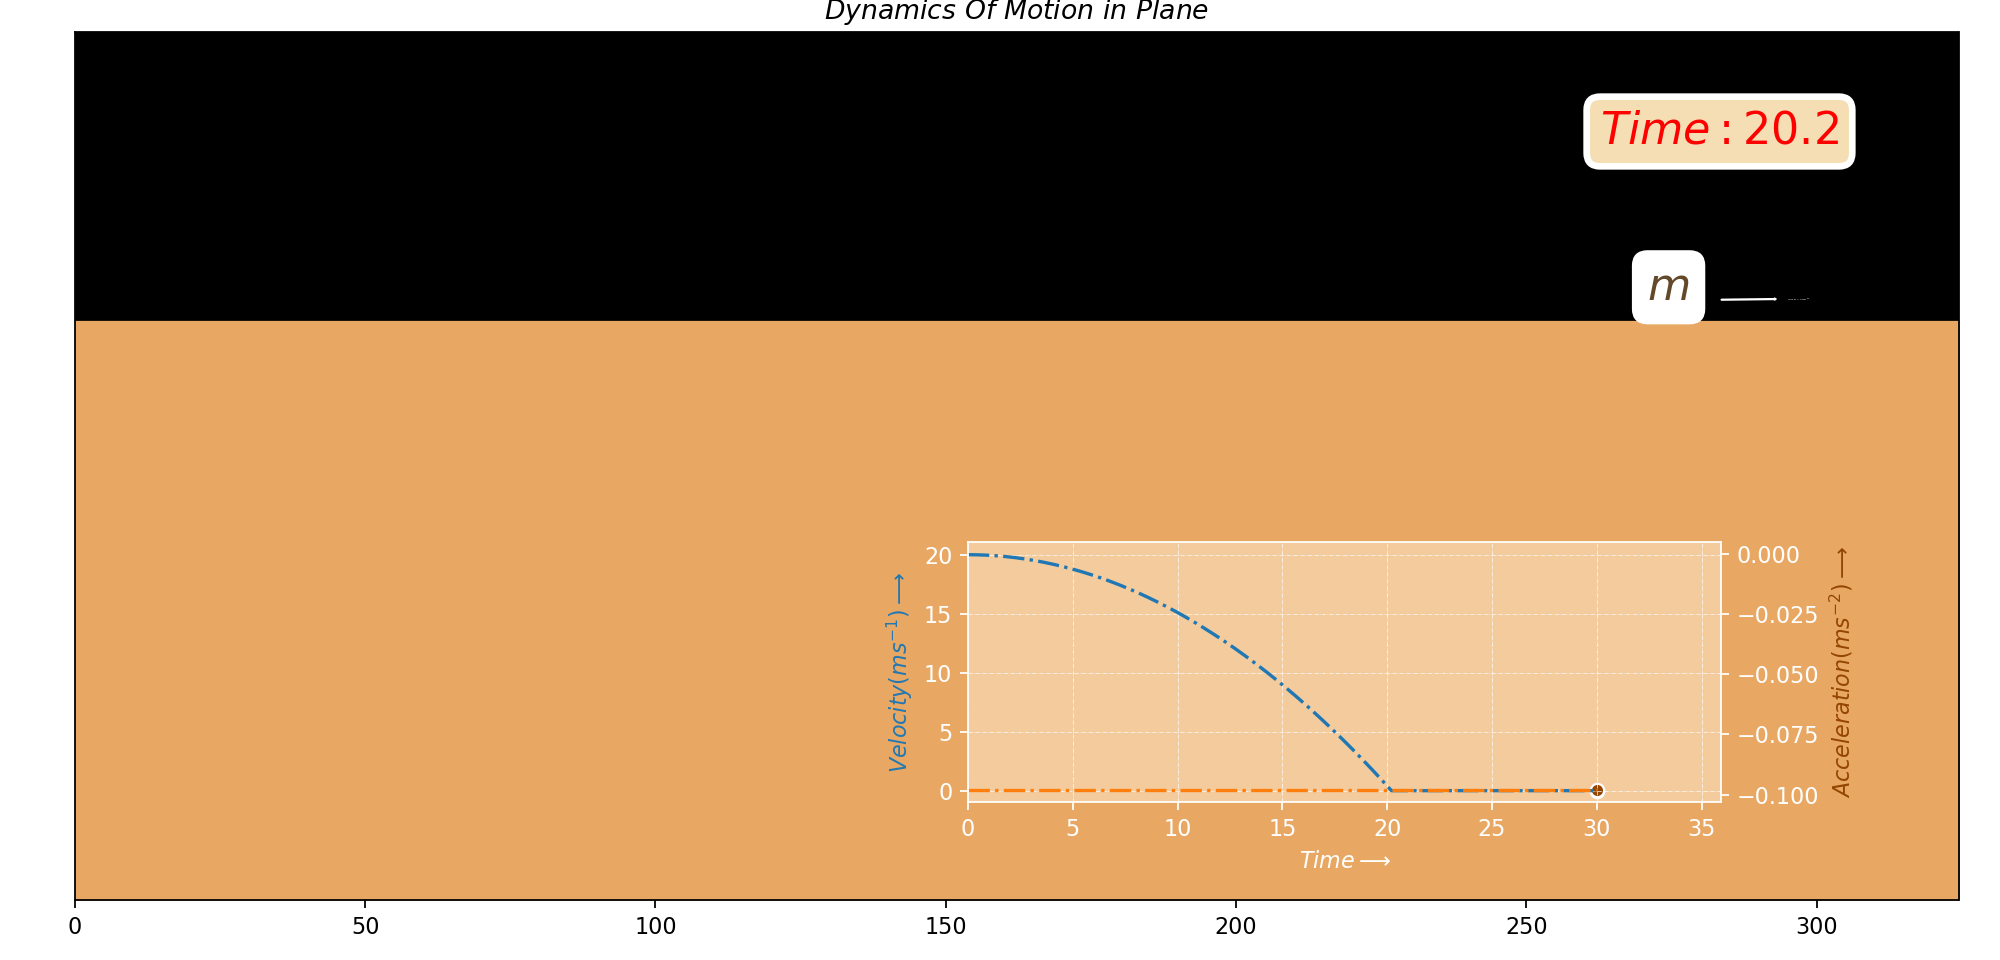

In [12]:
planeSim = PlaneSimulator(vel_0=20,air_drag = 0.0, timesteps=30)
planeSim.start_simulation()